In this post I wanted to do a quick follow up to a previous post about [predicting career nba performance from rookie year data](http://www.danvatterott.com/blog/2016/03/20/predicting-career-performance-from-rookie-performance/). 

After my previous post, I started to get a little worried about my career prediction model. Specifically, I started to wonder about whether my model was [underfitting or overfitting the data](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Underfitting occurs when the model has too much "bias" and cannot accomodate the data's shape. [Overfitting](https://en.wikipedia.org/wiki/Overfitting) occurs when the model is too flexible and can account for all variance in a data set - even variance due to noise. In this post, I will quickly re-create my player prediction model, and investigate whether underfitting and overfitting are a problem. 

Because this post largely repeats a previous one, I haven't written quite as much about the code. If you would like to read more about the code, see my previous posts.  

As usual, I will post all code as a jupyter notebook on my [github](https://github.com/dvatterott/jupyter_notebooks).

In [1]:
#import some libraries and tell ipython we want inline figures rather than interactive figures. 
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl

from __future__ import print_function

%matplotlib inline
pd.options.display.mpl_style = 'default' #load matplotlib for plotting
plt.style.use('ggplot') #im addicted to ggplot. so pretty.
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']


Load the data. Reminder - this data is still available on my [github](https://github.com/dvatterott/nba_project).

In [2]:
rookie_df = pd.read_pickle('nba_bballref_rookie_stats_2016_Mar_15.pkl') #here's the rookie year data

rook_games = rookie_df['Career Games']>50
rook_year = rookie_df['Year']>1980

#remove rookies from before 1980 and who have played less than 50 games. I also remove some features that seem irrelevant or unfair
rookie_df_games = rookie_df[rook_games & rook_year] #only players with more than 50 games. 
rookie_df_drop = rookie_df_games.drop(['Year','Career Games','Name'],1)

Load more data, and normalize it data for the [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). 

In [3]:
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle('nba_bballref_career_stats_2016_Mar_15.pkl')
df = df[df['G']>50]
df_drop = df.drop(['Year','Name','G','GS','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS','ORtg','DRtg','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'],1)
X = df_drop.as_matrix() #take data out of dataframe
ScaleModel = StandardScaler().fit(X)
X = ScaleModel.transform(X)

Use [k-means](https://en.wikipedia.org/wiki/K-means_clustering) to group players according to their performance. See my post on [grouping players](http://www.danvatterott.com/blog/2016/02/21/grouping-nba-players/) for more info. 

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

reduced_model = PCA(n_components=5, whiten=True).fit(X)

reduced_data = reduced_model.transform(X) #transform data into the 5 PCA components space
final_fit = KMeans(n_clusters=6).fit(reduced_data) #fit 6 clusters
df['kmeans_label'] = final_fit.labels_ #label each data point with its clusters

Run a separate regression on each group of players. I calculate mean absolute error (a variant of [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)) for each model. I used mean absolute error because it's on the same scale as the data, and easier to interpret. I will use this later to evaluate just how accurate these models are. Quick reminder - I am trying to predict career WS/48 with MANY predictor variables from rookie year performance such rebounding and scoring statistics. 

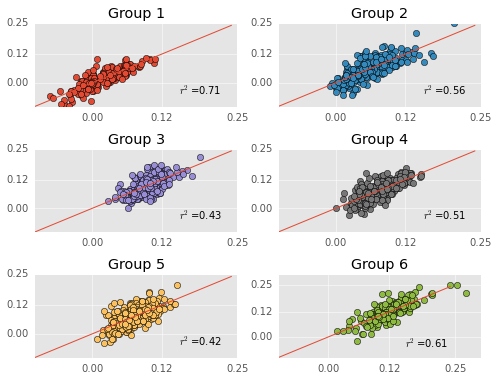

In [5]:
import statsmodels.api as sm 
from sklearn.metrics import mean_absolute_error #import function for calculating mean squared error. 

X = rookie_df.as_matrix() #take data out of dataframe

cluster_labels = df[df['Year']>1980]['kmeans_label']
rookie_df_drop['kmeans_label'] = cluster_labels #label each data point with its clusters

plt.figure(figsize=(8,6));

estHold = [[],[],[],[],[],[]]

score = []

for i,group in enumerate(np.unique(final_fit.labels_)):
           
    Grouper = df['kmeans_label']==group #do one regression at a time
    Yearer = df['Year']>1980
    
    Group1 = df[Grouper & Yearer]
    Y = Group1['WS/48'] #get predictor data
    
    Group1_rookie = rookie_df_drop[rookie_df_drop['kmeans_label']==group]
    Group1_rookie = Group1_rookie.drop(['kmeans_label'],1) #get predicted data

    X = Group1_rookie.as_matrix() #take data out of dataframe    
    
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    est = sm.OLS(Y,X) #fit with linear regression model
    est = est.fit()
    estHold[i] = est
    score.append(mean_absolute_error(Y,est.predict(X))) #calculate the mean squared error
    #print est.summary()
    
    plt.subplot(3,2,i+1) #plot each regression's prediction against actual data
    plt.plot(est.predict(X),Y,'o',color=plt.rcParams['axes.color_cycle'][i])
    plt.plot(np.arange(-0.1,0.25,0.01),np.arange(-0.1,0.25,0.01),'-')
    plt.title('Group %d'%(i+1))
    plt.text(0.15,-0.05,'$r^2$=%.2f'%est.rsquared)
    plt.xticks([0.0,0.12,0.25])
    plt.yticks([0.0,0.12,0.25]); 

More quick reminders - predicted performances are on the Y-axis, actual performances are on the X-axis, and the red line is the [identity line](https://en.wikipedia.org/wiki/Identity_line). Thus far, everything has been exactly the same as my previous post (although my group labels are different). 

I want to investigate whether the model is overfitting the data. If the data is overfitting the data, then the error should go up when training and testing with different datasets (because the model was fitting itself to noise and noise changes when the datasets change). To investigate whether the model overfits the data, I will evaluate whether the model "generalizes" via [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29).

The reason I'm worried about overfitting is I used a LOT of predictors in these models and the number of predictors might have allowed the model the model to fit noise in the predictors. 

In [8]:
from sklearn.linear_model import LinearRegression #I am using sklearns linear regression because it plays well with their cross validation function
from sklearn import cross_validation #import the cross validation function

X = rookie_df.as_matrix() #take data out of dataframe

cluster_labels = df[df['Year']>1980]['kmeans_label']
rookie_df_drop['kmeans_label'] = cluster_labels #label each data point with its clusters

for i,group in enumerate(np.unique(final_fit.labels_)):
           
    Grouper = df['kmeans_label']==group #do one regression at a time
    Yearer = df['Year']>1980
    
    Group1 = df[Grouper & Yearer]
    Y = Group1['WS/48'] #get predictor data
    
    Group1_rookie = rookie_df_drop[rookie_df_drop['kmeans_label']==group]
    Group1_rookie = Group1_rookie.drop(['kmeans_label'],1) #get predicted data

    X = Group1_rookie.as_matrix() #take data out of dataframe    
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    
    est = LinearRegression() #fit with linear regression model
    
    this_scores = cross_validation.cross_val_score(est, X, Y,cv=10, scoring='mean_absolute_error') #find mean square error across different datasets via cross validations
    print('Group '+str(i))
    print('Initial Mean Absolute Error: '+str(score[i])[0:6])
    print('Cross Validation MAE: '+str(np.median(np.abs(this_scores)))[0:6]) #find the mean MSE across validations

Group 0
Initial Mean Absolute Error: 0.0161
Cross Validation MAE: 0.0520
Group 1
Initial Mean Absolute Error: 0.0251
Cross Validation MAE: 0.0767
Group 2
Initial Mean Absolute Error: 0.0202
Cross Validation MAE: 0.0369
Group 3
Initial Mean Absolute Error: 0.0200
Cross Validation MAE: 0.0263
Group 4
Initial Mean Absolute Error: 0.0206
Cross Validation MAE: 0.0254
Group 5
Initial Mean Absolute Error: 0.0244
Cross Validation MAE: 0.0665


Above I print out the model's initial mean absolute error and median absolute error when fitting cross-validated data. 

The models definitely have more error when cross validated. The change in error is worse in some groups than others. For instance, error dramatically increases in Group 1. Keep in mind that the scoring measure here is mean absolute error, so error is in the same scale as WS/48. An average error of 0.04 in WS/48 is sizable, leaving me worried that the models overfit the data. 

Unfortunately, Group 1 is the "scorers" group, so the group with most the interesting players is where the model fails most...

Next, I will look into whether my models underfit the data. I am worried that my models underfit the data because I used linear regression, which has very little flexibility. To investigate this, I will plot the [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals) of each model. Residuals are the error between my model's prediction and the actual performance. 

Linear regression assumes that residuals are uncorrelated and evenly distributed around 0. If this is not the case, then the linear regression is underfitting the data. 

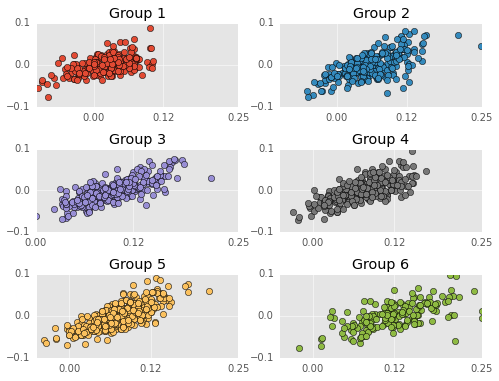

In [7]:
#plot the residuals. there's obviously a problem with under/over prediction

plt.figure(figsize=(8,6));

for i,group in enumerate(np.unique(final_fit.labels_)):
           
    Grouper = df['kmeans_label']==group #do one regression at a time
    Yearer = df['Year']>1980
    
    Group1 = df[Grouper & Yearer]
    Y = Group1['WS/48'] #get predictor data
    resid = estHold[i].resid #extract residuals
        
    plt.subplot(3,2,i+1) #plot each regression's prediction against actual data
    plt.plot(Y,resid,'o',color=plt.rcParams['axes.color_cycle'][i])
    plt.title('Group %d'%(i+1))
    plt.xticks([0.0,0.12,0.25])
    plt.yticks([-0.1,0.0,0.1]); 

Residuals are on the Y-axis and career performances are on the X-axis. Negative residuals are over predictions (the player is worse than my model predicts) and postive residuals are under predictions (the player is better than my model predicts). I don't test this, but the residuals appear VERY correlated. That is, the model tends to over estimate bad players (players with WS/48 less than 0.0) and under estimate good players. Just to clarify, non-correlated residuals would have no apparent slope.

This means the model is making systematic errors and not fitting the actual shape of the data. I'm not going to say the model is damned, but this is an obvious sign that the model needs more flexibility. 

No model is perfect, but this model definitely needs more work. I've been playing with more flexible models and will post these models here if they do a better job predicting player performance. 